In [ ]:
#uplist[uplist['shcode']=='000080']
#uplist[uplist['shcode']=='000080'].groupby(['shcode']).count()
#tmlist[tmlist['shcode']=='000080']
#tmlist[tmlist['shcode']=='000080'].groupby(['shcode']).count()
#df_bfaf2 = df_bfaf[['index','shcode']].drop_duplicates()

'''
#4-1 분리
s = df['index'].str.split(' ').apply(Series,1)#.fillna(0)
df = pd.merge(df, s,left_index =True, right_index =True ,how = 'left')
df['total_n'] = s.groupby(s.index).count().sum(axis=1)
del df['index']
df = df.fillna(0)
df = pd.merge(df, uplist[['shcode','upcode', 'upname']], how = 'left', on = ['shcode'])
df = pd.merge(df, tmlist[['shcode','tmcode', 'tmname']], how = 'left', on = ['shcode'])
df = pd.merge(df, shcode_list, how = 'left', on = ['shcode'])

df.groupby(['upcode','upname'])['total_n'].count().sort_values(ascending= False)
df.groupby(['tmcode','tmname'])['total_n'].count().sort_values(ascending= False)

li = [x for x in range(0,12)]
df.columns.isin(li)
df2 = df.copy()
for i in df.columns[df.columns.isin(li)]:
    df2[i] = df2[i].str.slice(stop = 6) 
'''

In [1]:
import sqlite3
import time
import pandas as pd
import numpy as np
import query
import preprocesser
import datetime
import pandas.tseries.offsets as of  # for timeoffset
from pandas import Series


In [94]:
df = pd.read_csv("df.csv",encoding = 'ms949', dtype = {'shcode':str })
jupo = pd.read_csv("jupo.csv",encoding = 'ms949', dtype = {'shcode':str})
per_df = pd.read_csv("per_df.csv",encoding = 'ms949', dtype = {'shcode':str})
rrr = pd.read_csv("rrr.csv",encoding = 'ms949', dtype = {'shcode':str})

In [95]:
del df['Unnamed: 0']
del jupo['Unnamed: 0']
del per_df['Unnamed: 0']
del rrr['Unnamed: 0']

In [96]:
from functools import reduce
dfs = [df, jupo, per_df, rrr]
df_final = reduce(lambda left, right: pd.merge(left,right,left_on=['shcode','target_day'], right_on=['shcode','date']), dfs)
df_final.columns

Index(['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname',
       'shname', 'target_m', 'next_target_day', 'shcode2', 'y', 'init_jupo',
       'end_jupo', 'init_month', 'end_month', 'init_week', 'end_week',
       'check_init_day2', 'date_x', 'max_vol', 'max_jupo', 'contin_jupo',
       'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio', 'tusin_vol_ratio',
       'bank_vol_ratio', 'jong_vol_ratio', 'fund_vol_ratio', 'etcom_vol_ratio',
       'for_reg_vol_ratio', 'for_noreg_vol_ratio', 'nat_no_vol_ratio',
       'per_vol_ratio', 'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio',
       'date_y', 'obv', 'date', 'open_', 'low', 'high', 'close', 'volume',
       'range_position', 'month_ma5_score', 'week_ma5_score',
       'week_ma20_score', 'week_golden_cross', 'week_dead_cross', 'week_up',
       'week_down'],
      dtype='object')

In [97]:
df.shape, jupo.shape, per_df.shape, rrr.shape , df_final.shape

((2479, 18), (2479, 20), (2479, 3), (2479, 15), (2477, 53))

In [98]:
df_final = df_final[['y', 'shcode', 'upcode', 'target_m', 
                     'max_vol', 'max_jupo', 'contin_jupo',
                     'samo_vol_ratio', 'sec_vol_ratio', 'ins_vol_ratio', 
                     'tusin_vol_ratio', 'bank_vol_ratio', 'jong_vol_ratio', 
                     'fund_vol_ratio', 'etcom_vol_ratio', 'for_reg_vol_ratio', 
                     'for_noreg_vol_ratio', 'nat_no_vol_ratio', 'per_vol_ratio', 
                     'com_vol_ratio', 'for_vol_ratio', 'etc_vol_ratio', 'obv', 
                     'close', 'volume','range_position', 
                     'month_ma5_score', 'week_ma5_score', 'week_ma20_score', 
                     'week_golden_cross', 'week_dead_cross', 'week_up', 
                     'week_down']].drop_duplicates()

In [99]:
df_final.shape

(2473, 33)

ml

In [ ]:
#dtype변환
#https://github.com/TeamLab/machine_learning_from_scratch_with_python/blob/master/code/ch9/4_Logistic_Regression_with_sklearn.ipynb

In [100]:
df_final.dtypes

y                        int64
shcode                  object
upcode                 float64
target_m                 int64
max_vol                float64
max_jupo                object
contin_jupo              int64
samo_vol_ratio         float64
sec_vol_ratio          float64
ins_vol_ratio          float64
tusin_vol_ratio        float64
bank_vol_ratio         float64
jong_vol_ratio         float64
fund_vol_ratio         float64
etcom_vol_ratio        float64
for_reg_vol_ratio      float64
for_noreg_vol_ratio    float64
nat_no_vol_ratio       float64
per_vol_ratio          float64
com_vol_ratio          float64
for_vol_ratio          float64
etc_vol_ratio          float64
obv                    float64
close                    int64
volume                   int64
range_position         float64
month_ma5_score        float64
week_ma5_score         float64
week_ma20_score        float64
week_golden_cross        int64
week_dead_cross          int64
week_up                  int64
week_dow

In [101]:
#분기변경
df_final['target_m'] = pd.to_datetime(df_final['target_m'],format = "%Y%m").dt.quarter

#upcode, null값 처리
df_final['upcode'] = df_final['upcode'].fillna(0).astype(int)
df_final['month_ma5_score'] = df_final['month_ma5_score'].fillna(0)

# 총액계산
df_final['volume_money'] = df_final['close'] * df_final['volume']

del df_final['close']
del df_final['volume']

In [102]:
df_final.isnull().sum().sum()

0

In [103]:
for col in ['upcode','target_m','max_jupo']:
    df_final[col] = df_final[col].astype('category')

In [104]:
df_final.dtypes

y                         int64
shcode                   object
upcode                 category
target_m               category
max_vol                 float64
max_jupo               category
contin_jupo               int64
samo_vol_ratio          float64
sec_vol_ratio           float64
ins_vol_ratio           float64
tusin_vol_ratio         float64
bank_vol_ratio          float64
jong_vol_ratio          float64
fund_vol_ratio          float64
etcom_vol_ratio         float64
for_reg_vol_ratio       float64
for_noreg_vol_ratio     float64
nat_no_vol_ratio        float64
per_vol_ratio           float64
com_vol_ratio           float64
for_vol_ratio           float64
etc_vol_ratio           float64
obv                     float64
range_position          float64
month_ma5_score         float64
week_ma5_score          float64
week_ma20_score         float64
week_golden_cross         int64
week_dead_cross           int64
week_up                   int64
week_down                 int64
volume_m

In [105]:
df_mordified = pd.get_dummies(df_final)

In [106]:
df_mordified.iloc[0].T

y                         0.000000e+00
max_vol                   4.050743e-02
contin_jupo               1.000000e+00
samo_vol_ratio            4.080974e-03
sec_vol_ratio             5.235178e-03
ins_vol_ratio             3.285140e-05
tusin_vol_ratio           7.657741e-03
bank_vol_ratio           -2.329683e-04
jong_vol_ratio            7.753729e-05
fund_vol_ratio            1.919240e-03
etcom_vol_ratio          -3.229675e-04
for_reg_vol_ratio        -5.765619e-02
for_noreg_vol_ratio      -8.161519e-05
nat_no_vol_ratio         -1.217213e-03
per_vol_ratio             4.050743e-02
com_vol_ratio             1.755334e-02
for_vol_ratio            -5.773780e-02
etc_vol_ratio            -1.540180e-03
obv                       4.393838e+06
range_position            9.000000e-01
month_ma5_score           7.000000e-01
week_ma5_score            7.000000e-01
week_ma20_score           1.000000e+00
week_golden_cross         0.000000e+00
week_dead_cross           0.000000e+00
week_up                  

In [108]:
y_data = df_mordified.iloc[:, 0].as_matrix().reshape(-1, 1)
x_data = df_mordified.iloc[:, 1:].as_matrix()

y_data.shape, x_data.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


((2473, 1), (2473, 1110))

In [ ]:
'''
#범주형숫자형을 -> 변환함
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder() 
onehot_encoder = OneHotEncoder()

train_y = label_encoder.fit_transform(info['class2']) 
train_y = train_y.reshape(len(train_y), 1) 
train_y = onehot_encoder.fit_transform(train_y)
'''

In [109]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_data)
x_data_n = scaler.transform(x_data) #전체데이터 minmax

In [ ]:
#ch12 decision_tree_w_sklearn.ipynb
#https://github.com/TeamLab/machine_learning_from_scratch_with_python/blob/master/code/ch12/4_decision_tree_w_sklearn.ipynb

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data_n, y_data, test_size=0.33, random_state=42)

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

algorithmes = [LogisticRegression(), DecisionTreeClassifier()]

In [115]:
c_params = [0.1,  5.0, 7.0, 10.0, 15.0, 20.0, 100.0]


params = []
params.append([{
    "solver" : ["saga"],
    "penalty" : ["l1"],
    "C" : c_params
    },{
    "solver" : ['liblinear'],
    "penalty" : ["l2"],
    "C" : c_params
    }
    ])
params.append({
    "criterion" : ["gini", "entropy"],
    "max_depth" : [10,8,7,6,5,4,3,2],
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9]})

In [116]:
params

[[{'solver': ['saga'],
   'penalty': ['l1'],
   'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0]},
  {'solver': ['liblinear'],
   'penalty': ['l2'],
   'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0]}],
 {'criterion': ['gini', 'entropy'],
  'max_depth': [10, 8, 7, 6, 5, 4, 3, 2],
  'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]}]

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

scoring = ['accuracy']
estimator_results = []
for i, (estimator, params) in enumerate(zip(algorithmes,params)):
    gs_estimator = GridSearchCV(
            refit="accuracy", estimator=estimator,param_grid=params, scoring=scoring, cv=5, verbose=1, n_jobs=4)
    print(gs_estimator)

    gs_estimator.fit(X_train, y_train)
    estimator_results.append(gs_estimator)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'solver': ['saga'], 'penalty': ['l1'], 'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0]}, {'solver': ['liblinear'], 'penalty': ['l2'], 'C': [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=['accuracy'], verbose=1)
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:  1.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 8, 7, 6, 5, 4, 3, 2], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=['accuracy'], verbose=1)
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   53.9s finished


In [120]:
estimator_results[0].best_score_, estimator_results[1].best_score_

(0.7095410628019324, 0.7022946859903382)

In [122]:
import pandas as pd
from collections import defaultdict

result_df_dict = {}

result_attributes = ["model", "accuracy", "penalty", "solver", "C", "criterion", "max_depth", "min_samples_leaf"]
result_dict = defaultdict(list)

algorithm_name= ["LogisticRegression", "DecisionTreeClassifier"]

for i, estimators in enumerate(estimator_results):
    number_of_estimators = len(estimators.cv_results_["mean_fit_time"])

    for idx_estimator in range(number_of_estimators):
        result_dict["model"].append(algorithm_name[i])
        result_dict["accuracy"].append(
            estimators.cv_results_["mean_test_accuracy"][idx_estimator])
            
    for param_value in estimators.cv_results_["params"]:
        for k,v in param_value.items():
            result_dict[k].append(v)
    for attr_name in result_attributes:
        if len(result_dict[attr_name]) < len(result_dict["accuracy"]):
            result_dict[attr_name].extend([None for i in range(number_of_estimators)])

In [123]:
result_df = pd.DataFrame(result_dict, columns=result_attributes)
result_df.sort_values("accuracy",ascending=False).head(n=100)

,model,accuracy,penalty,solver,C,criterion,max_depth,min_samples_leaf
0,LogisticRegression,0.709541,l1,saga,0.1,None,NaN,NaN
7,LogisticRegression,0.708937,l2,liblinear,0.1,None,NaN,NaN
149,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,1.0
154,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,6.0
153,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,5.0
152,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,4.0
151,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,3.0
150,DecisionTreeClassifier,0.702295,None,None,NaN,entropy,2.0,2.0
156,DecisionTreeClassifier,0.698671,None,None,NaN,entropy,2.0,8.0
155,DecisionTreeClassifier,0.698671,None,None,NaN,entropy,2.0,7.0


In [132]:
estimator_results[1].best_estimator_.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [130]:
df_mordified.iloc[:, 1:].columns

Index(['max_vol', 'contin_jupo', 'samo_vol_ratio', 'sec_vol_ratio',
       'ins_vol_ratio', 'tusin_vol_ratio', 'bank_vol_ratio', 'jong_vol_ratio',
       'fund_vol_ratio', 'etcom_vol_ratio',
       ...
       'max_jupo_etc_vol', 'max_jupo_etcom_vol', 'max_jupo_for_noreg_vol',
       'max_jupo_for_reg_vol', 'max_jupo_for_vol', 'max_jupo_fund_vol',
       'max_jupo_per_vol', 'max_jupo_samo_vol', 'max_jupo_sec_vol',
       'max_jupo_tusin_vol'],
      dtype='object', length=1110)

In [133]:
estimator_results[0].best_estimator_.coef_

array([[ 0.        , -0.10196802,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
best_tree = estimator_results[1].best_estimator_
column_names=  pd.get_dummies(all_df).columns

In [ ]:
column_names

In [ ]:
import pydotplus
from sklearn.externals.six import StringIO
from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(best_tree, out_file=dot_data, feature_names=column_names) 

graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("titanic.png")
from IPython.core.display import Image 
Image(filename='titanic.png')

pca

In [ ]:
'''
from sklearn.preprocessing import StandardScaler
features = df_mordified[:,1].columns
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['y']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
'''

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_data_n)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [136]:
finalDf = pd.concat([principalDf, df_mordified[['y']]], axis = 1)

In [138]:
import matplotlib.pyplot as plt

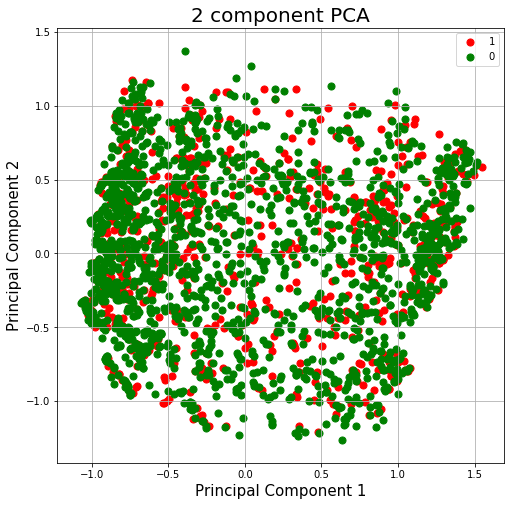

In [141]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['y'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

model selectd

In [ ]:
final = pd.merge(rrr, per_df, how = 'left', on = ['date','index','shcode'])
final[['index' ,'shcode','shname', 'target_m', 'date', 'close_ratio', 'open_', 'low', 'high', 'close','volume' , 
       'range_position', 'squeezed',
       'month_ma5_score', 'high_month', 'for_net_buy_sum','com_net_buy_sum', 'per_net_buy_sum',
       'week_ma5_score','week_ma20_score',
       'week_golden_cross', 'week_dead_cross', 'week_up', 'week_down',
       'close_ma5', 'close_ma10', 'close_ma20', 'close_ma60','close_ma120',
       'obv',
       'rsi14', 'rsi14_signal', 'slowk', 'slowd', 'ma_g_c', 'ma_d_c', 'rsi_g_c', 'rsi_d_c',
       'stoc_g_c', 'stoc_d_c'
      ]].to_csv("bf_target_day_using_weekly_v3.csv",encoding = 'ms949')

In [24]:
target_day_diff.iloc[1] <= datetime.timedelta(days = 30)

True

In [22]:
(next_target_day_list - target_day_list).iloc[1]

Timedelta('21 days 00:00:00')

In [6]:
target_day_list.iloc[0]

Timestamp('2019-04-24 00:00:00')

In [7]:
target_day_list.iloc[0] - of.DateOffset(n=1)

Timestamp('2019-04-23 00:00:00')

In [6]:
df.shape

(2471, 9)

In [13]:
df[['shcode','shname','target_day']].groupby(['shcode','shname','target_day'])['shcode'].count().sort_values(ascending= False)

shcode  shname    target_day
057030  YBM넷      20190520      2
                  20181220      2
                  20190910      2
                  20190905      2
                  20190521      2
                  20181219      2
                  20190211      2
256840  한국비엔씨     20190821      2
036580  팜스코       20190917      1
036540  SFA반도체    20190814      1
                  20190507      1
                  20190429      1
                  20190423      1
950170  JTC       20190227      1
036200  유니셈       20190314      1
036540  SFA반도체    20190422      1
036480  대성미생물     20190917      1
                  20190531      1
                  20190418      1
                  20190129      1
036580  팜스코       20190925      1
036630  세종텔레콤     20190906      1
036640  HRS       20190916      1
036810  에프에스티     20190212      1
037070  파세코       20190327      1
                  20190326      1
                  20190306      1
037030  파워넷       20190827      1
                  2

In [10]:
df[['shcode','shname','target_day']].drop_duplicates().shape

(2463, 3)

In [8]:
#df.to_excel('11111.xlsx')

In [4]:
df.columns

Index(['shcode', 'target_day', 'upcode', 'upname', 'tmcode', 'tmname',
       'shname', 'target_m'],
      dtype='object')

In [6]:
# 최근
df[df['target_m']=='201911'].groupby(['upcode','upname','target_m'])['shcode'].count().sort_values(ascending= False)

upcode  upname       target_m
320.0   제       약    201911      12
319.0   화       학    201911      10
308.0   유       통    201911       9
307.0   건       설    201911       9
12.0    기       계    201911       9
19.0    운 수 창 고      201911       8
345.0   기술성장 기업      201911       7
315.0   음식료 담배       201911       7
11.0    철 강 금 속      201911       7
324.0   전 기/전 자      201911       6
301.0   코스닥 종합       201911       6
311.0   금       융    201911       5
338.0   오락/문화        201911       5
9.0     의   약  품     201911       5
325.0   의 료/정 밀      201911       5
114.0   KP200 에너지화학  201911       4
16.0    유   통  업     201911       4
4.0     소   형  주     201911       4
304.0   IT   종  합    201911       4
303.0   기타 서비스       201911       3
333.0   컴퓨터서비스       201911       3
26.0    서 비 스 업      201911       3
310.0   운       송    201911       2
316.0   섬 유/의 류      201911       2
317.0   종 이/목 재      201911       2
336.0   반   도  체     201911       2
323.0   기 계 장 비      201911       

In [ ]:
#최소
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].min().sort_values(ascending= False)
#최대
df[df['upcode']==308].groupby(['upcode','upname'])['target_day'].max().sort_values(ascending= False)

In [7]:
df[df['target_m']=='201911'].groupby(['tmcode','tmname','target_m'])['shcode'].count().sort_values(ascending= False)


tmcode  tmname          target_m
172.0   제약업체            201911      11
377.0   치매 관련주          201911      11
110.0   화장품             201911       7
427.0   구충제(펜벤다졸 등)     201911       6
421.0   日 불매운동 관련주      201911       6
311.0   고령화 사회(노인복지)    201911       6
166.0   항공/저가 항공사(LCC)  201911       6
376.0   유전자 치료제/분석      201911       5
335.0   재난/안전(지진 등)     201911       5
331.0   가상화폐(비트코인 등)    201911       5
387.0   블록체인            201911       5
417.0   아프리카 돼지열병(ASF)  201911       5
27.0    자동차부품           201911       5
171.0   비철금속            201911       4
111.0   지주사             201911       4
33.0    LED             201911       4
149.0   U-HEALTHCARE    201911       4
279.0   스마트폰            201911       4
393.0   갤럭시 부품주         201911       4
401.0   원자력발전소 해체       201911       4
420.0   2019 하반기 신규상장   201911       4
113.0   음식료업종           201911       3
191.0   태양광에너지          201911       3
404.0   폴더블폰            201911       3
128.0   엔터테인먼트          201911 

In [9]:
df.head()

,shcode,target_day,upcode,upname,tmcode,tmname,shname,target_m
0,000080,20190424,1.0,종 합,421.0,日 불매운동 관련주,하이트진로,201904
1,000140,20190708,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
2,000140,20190729,1.0,종 합,421.0,日 불매운동 관련주,하이트진로홀딩스,201907
3,000150,20190416,1.0,종 합,111.0,지주사,두산,201904
4,000150,20190726,1.0,종 합,111.0,지주사,두산,201907


In [75]:
c.to_excel("1234.xlsx",encoding = 'ms949')

In [76]:
a = query.query_jupo_vol(fin_result['shcode'].iloc[439], fr=fin_result['init_jupo'].iloc[439], to='20191231')
a.to_excel("1234-1.xlsx",encoding = 'ms949')

In [37]:
b = query.query_finance(fin_result['shcode'].iloc[439])

In [39]:
b.columns

Index(['date', 'shcode', 'close', 'volume', 'volume_money', 'high_52',
       'high_52_day', 'low_52', 'low_52_day', 'rotate_ratio', 'burn_ratio',
       'per', 'total_vol', 'ev_ratio', 'vol_scale', 'market_value'],
      dtype='object')

In [38]:
b['total_vol'].astype(int) * 1000

0    13905000
Name: total_vol, dtype: int32